Model Workflow
Data Loading &  Processing
()


Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)

Further Feature engineering: implementing Time Series 

- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization

Feature Selection through Pre-calculated Technical Indicators 

Trend prediction: inputs - SMA, EMA, using Linear regression (OLS), or support vector machine
Market Regime Detection: inputs - RSI, ATR, SMA using K-means Clustering
Buy/Sell Signals for Binary Classification: inputs - RSI, MACD, OBV, using Random Forest Classifier 

Model Training & Prediction: Machine Learning

Time Series Modelling: ARIMA for short -term price, GARCH for volatility forecasting 
Price Forecasting: LSTM, utilizing keras to implement long-term price forecasting
Strategy Implementation:
Combine signals and implement reinforcement learning to create a trading strategy

Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


In [54]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago 
end_date = datetime(2025, 2, 28)  # Last day of February 2025
start_date = end_date - timedelta(days=365)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


                open      high       low     close       volume
timestamp                                                      
2024-02-29  62432.11  63676.35  60364.70  61130.98  78425.07603
2024-03-01  61130.99  63114.23  60777.00  62387.90  47737.93473
2024-03-02  62387.90  62433.19  61561.12  61987.28  25534.73659
2024-03-03  61987.28  63231.88  61320.00  63113.97  28994.90903
2024-03-04  63113.97  68499.00  62300.00  68245.71  84835.16005
                open      high       low     close       volume
timestamp                                                      
2025-03-15  83983.19  84676.28  83618.00  84338.44  11324.73320
2025-03-16  84338.44  85117.04  81981.12  82574.53  17596.12531
2025-03-17  82574.52  84756.83  82456.00  84010.03  17214.74358
2025-03-18  84010.02  84021.74  81134.66  82715.03  17610.89883
2025-03-19  82715.03  83280.00  82547.16  83159.04   3628.72240


In [55]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA'] = SMAIndicator(data['close'], window=14).sma_indicator()
    data['EMA'] = EMAIndicator(data['close'], window=14).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_hist'] = macd.macd_diff()
    data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    data['MFI'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=14)
    data['ATR'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()
    bands = BollingerBands(data['close'], window=20, window_dev = 2)
    data['upper_band'] = bands.bollinger_hband()
    data['middle_band'] = bands.bollinger_mavg()
    data['lower_band'] = bands.bollinger_lband() 
    data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    return data 

#handle missing values
def handle_missing_data(data):
    data.fillna(method = 'ffill', inplace=True)
    data.fillna(method = 'bfill', inplace = True)
    return data 

# Normalization
def normalize_data(df):
    scaler = MinMaxScaler()
    df[['close', 'SMA', 'EMA', 'MACD', 'OBV', 'ATR']] = scaler.fit_transform(df[['close', 'SMA', 'EMA', 'MACD', 'OBV', 'ATR']])
    return df

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())
print(btc_data.info())


                open      high       low     close       volume      SMA  \
timestamp                                                                  
2024-02-29  62432.11  63676.35  60364.70  0.137369  78425.07603  0.20924   
2024-03-01  61130.99  63114.23  60777.00  0.161456  47737.93473  0.20924   
2024-03-02  62387.90  62433.19  61561.12  0.153779  25534.73659  0.20924   
2024-03-03  61987.28  63231.88  61320.00  0.175371  28994.90903  0.20924   
2024-03-04  63113.97  68499.00  62300.00  0.273716  84835.16005  0.20924   

                 EMA        RSI     MACD  MACD_signal   MACD_hist       OBV  \
timestamp                                                                     
2024-02-29  0.230905  77.822116  0.39193  1008.875495 -145.010934  0.644000   
2024-03-01  0.230905  77.822116  0.39193  1008.875495 -145.010934  0.693552   
2024-03-02  0.230905  77.822116  0.39193  1008.875495 -145.010934  0.667047   
2024-03-03  0.230905  77.822116  0.39193  1008.875495 -145.010934  0.697

C:\Users\ryant\AppData\Local\Temp\ipykernel_13860\1400999956.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = 'ffill', inplace=True)
C:\Users\ryant\AppData\Local\Temp\ipykernel_13860\1400999956.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = 'bfill', inplace = True)


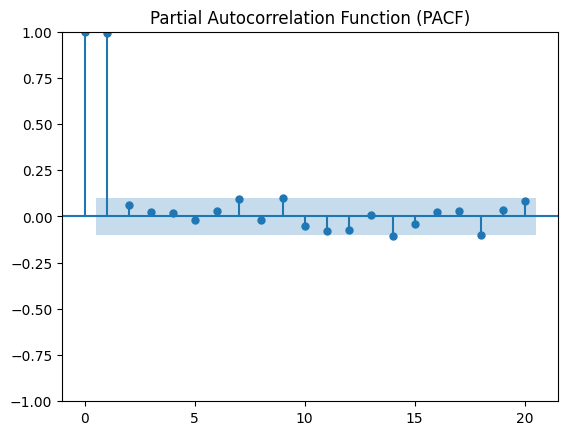

In [56]:
# Calculate weighted averages using regression on lagged values
def calculate_weighted_averages(data, lags):
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = data['close'].shift(i)
    data.dropna(inplace=True)

    X = data[[f'lag_{i}' for i in range(1, lags + 1)]]
    y = data['close']
    model = LinearRegression()
    model.fit(X, y)
    weights = model.coef_
    data['weighted_avg'] = np.dot(X, weights)

calculate_weighted_averages(btc_data, 5)

# Plot PACF to identify autoregressive lags
plot_pacf(data['close'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

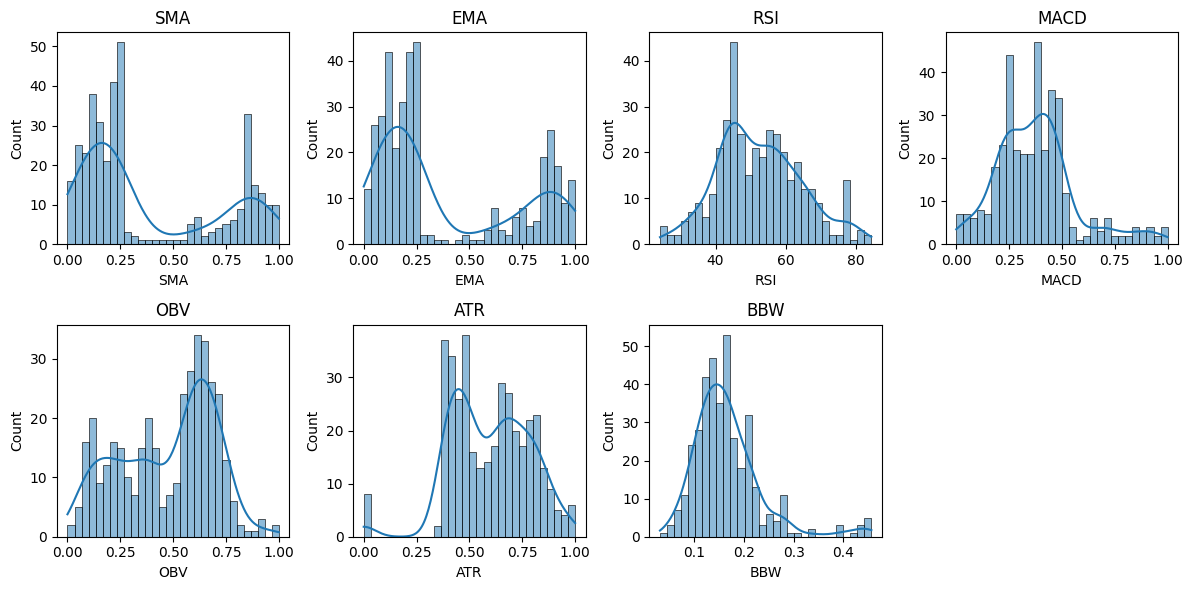

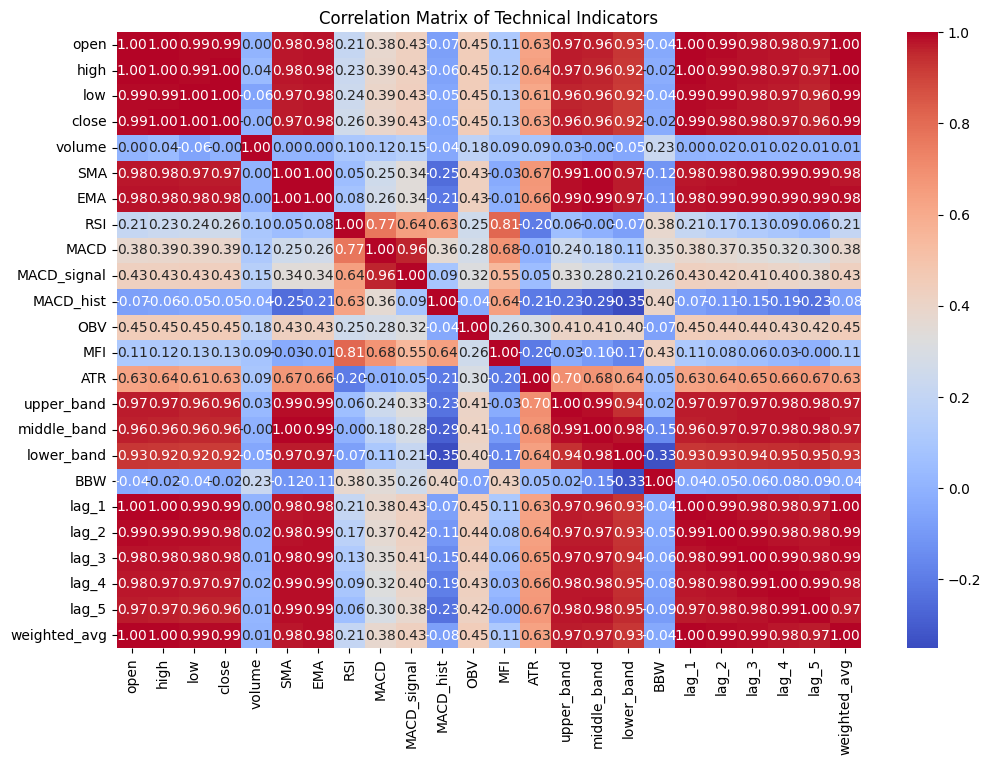

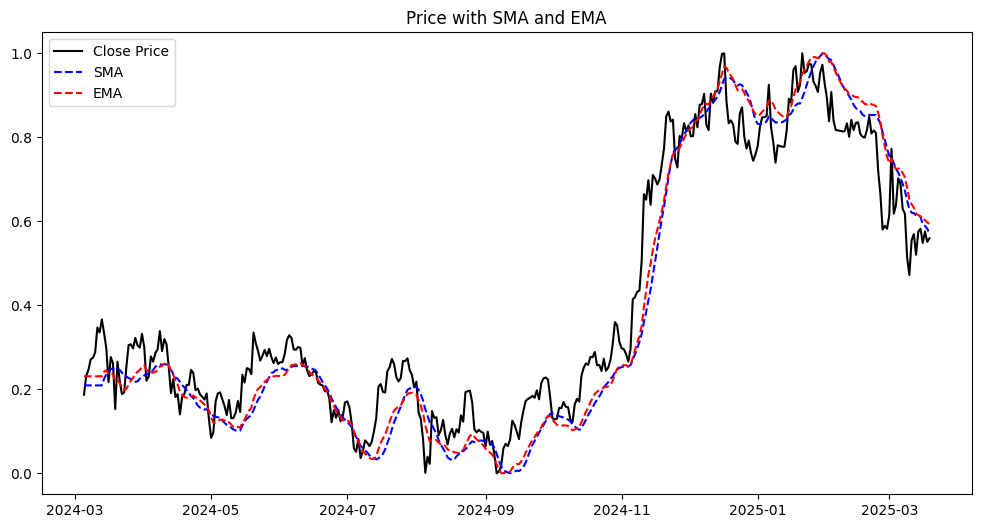

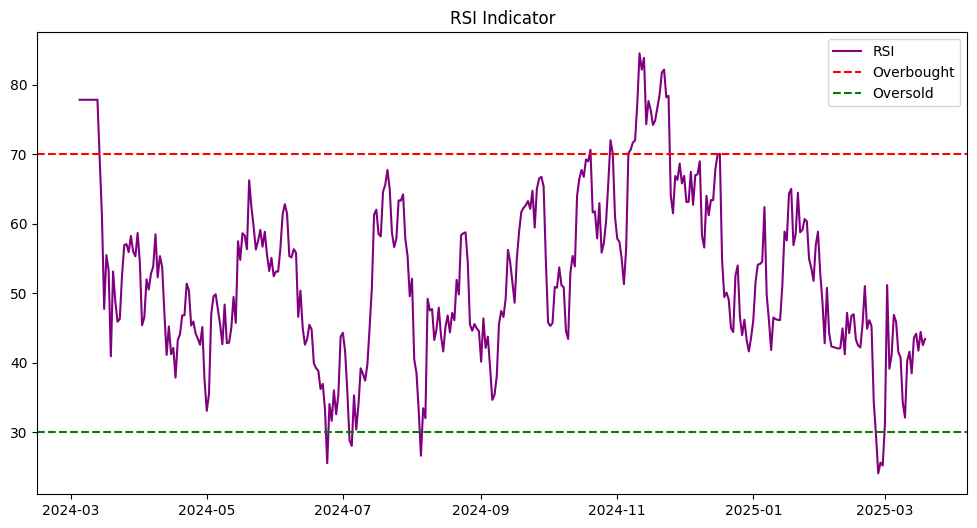

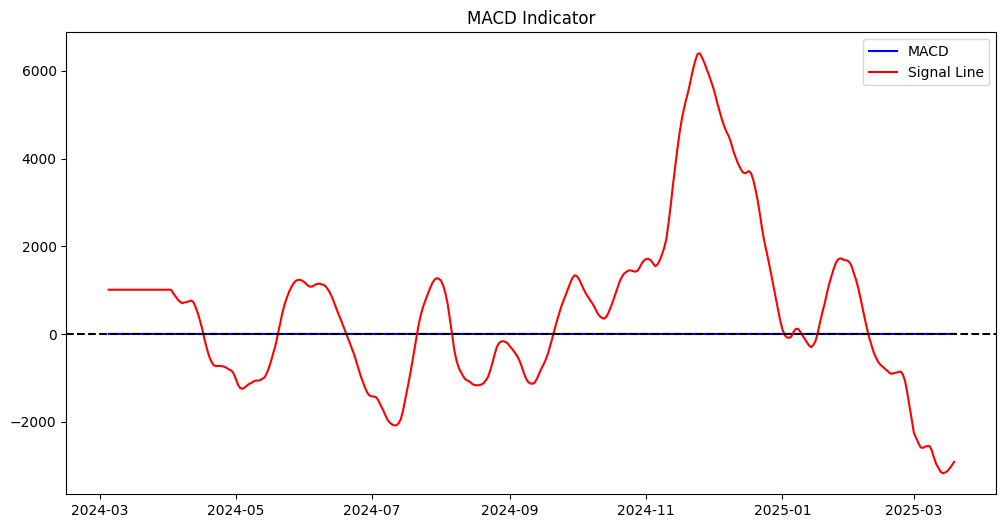

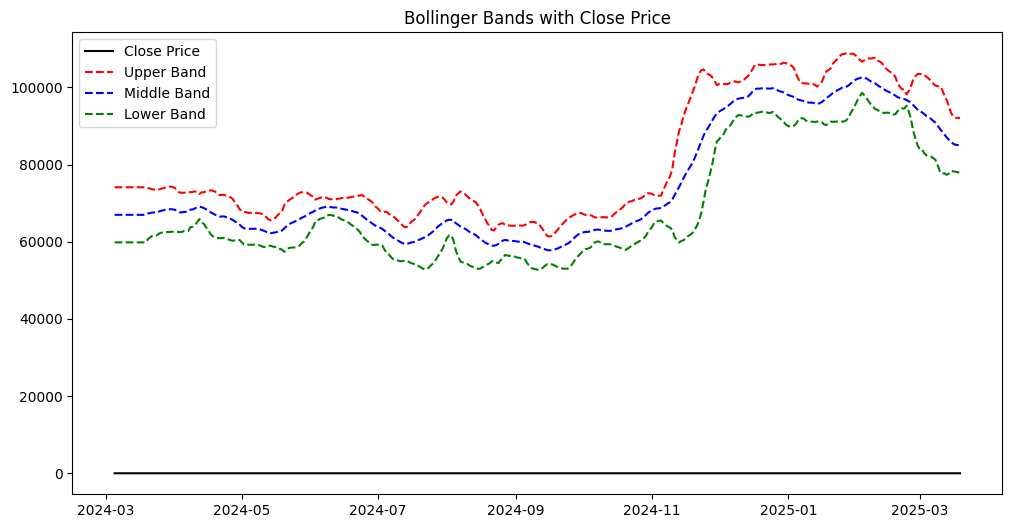

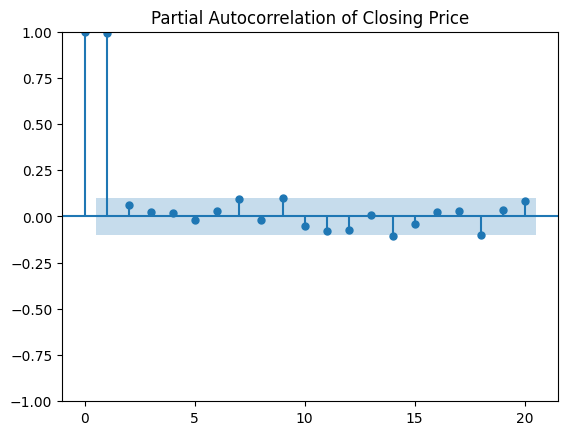

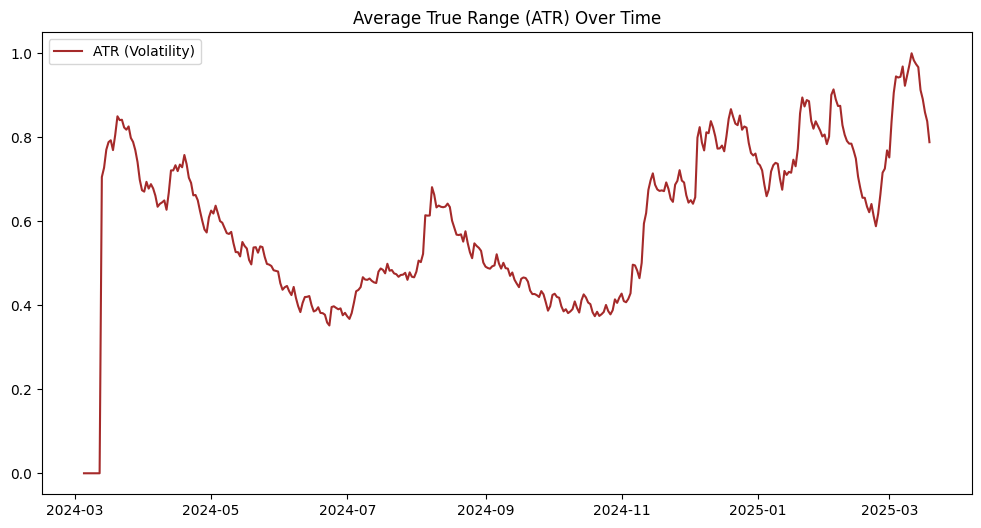

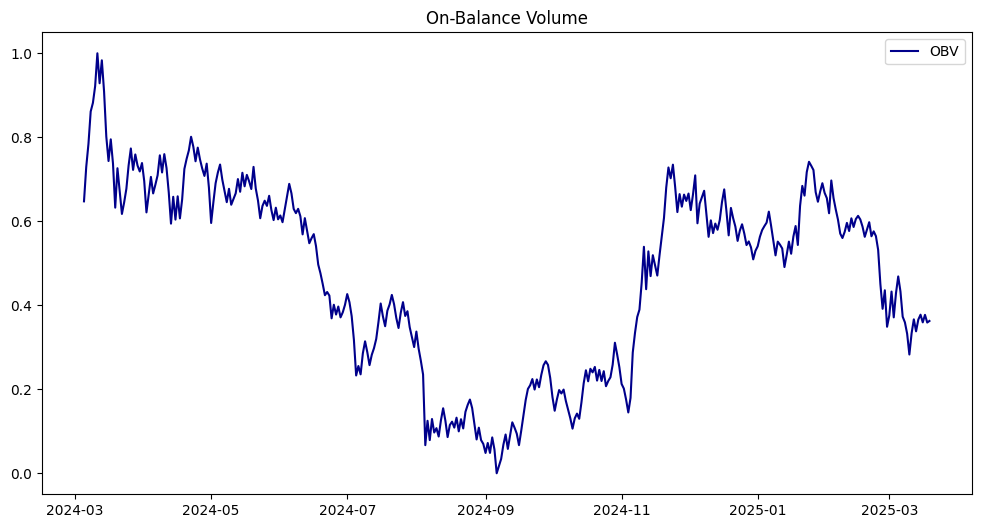

In [57]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

data = btc_data

#Distribution of Each Indicaor 
indicators = ['SMA', 'EMA', 'RSI', 'MACD', 'OBV', 'ATR', 'BBW']  # Select key indicators

plt.figure(figsize=(12, 6))
for i, indicator in enumerate(indicators):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[indicator], kde=True, bins=30)
    plt.title(indicator)
plt.tight_layout()
plt.show()

#Check for Correlations(Feature Redundancy)
#Some indicators might be highly correlated, making them redundant
#If correlation > 0.85, remove one of the correlated features.
# Example: SMA and EMA are usually correlated → Keep only one.
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

#Comparing Indicators with closing prices (Plot Trends Over Time)
# Check how SMA and EMA interact with price.
# Identify points where indicators signal trend reversals.

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
plt.legend()
plt.title("Price with SMA and EMA")
plt.show()

#Identify Overbought & Oversold Conditions (RSI & MACS)
# A. RSI (Relative Strength Index)
# RSI > 70 → Overbought (possible sell signal)
# RSI < 30 → Oversold (possible buy signal)
# Are most RSI values in a normal range (30-70)?
# Do RSI peaks align with price reversals?
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI'], label="RSI", color="purple")
plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
plt.legend()
plt.title("RSI Indicator")
plt.show()

# B. MACD (Moving Average Convergence Divergence)
# MACD > Signal Line → Bullish
# MACD < Signal Line → Bearish
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['MACD'], label='MACD', color='blue')
plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
plt.axhline(0, linestyle="dashed", color="black")
plt.legend()
plt.title("MACD Indicator")
plt.show()


#Analyze Bollinger Bands(Volatility)
# Price above upper band → Overbought
# Price below lower band → Oversold
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['upper_band'], label='Upper Band', linestyle='dashed', color='red')
plt.plot(data.index, data['middle_band'], label='Middle Band', linestyle='dashed', color='blue')
plt.plot(data.index, data['lower_band'], label='Lower Band', linestyle='dashed', color='green')
plt.legend()
plt.title("Bollinger Bands with Close Price")
plt.show()

#Aurocorrelation & Seasonality
#Check if past price values influence future prices using Partial Autocorrelation (PACF).
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['close'], lags=20)
plt.title("Partial Autocorrelation of Closing Price")
plt.show()

#Detect Market Regimes
# High ATR = High volatility (trend breakout).
# Low ATR = Sideways market
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['ATR'], label="ATR (Volatility)", color="brown")
plt.legend()
plt.title("Average True Range (ATR) Over Time")
plt.show()

#Volume & Trend Analysis
# A. On-Balance Volume (OBV)
# Check if OBV trends match price movements.
# Action:
# OBV rising = Accumulation (bullish).
# OBV falling = Distribution (bearish).
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['OBV'], label="OBV", color="darkblue")
plt.legend()
plt.title("On-Balance Volume")
plt.show()



## ARIMA

Preprocess Data

In [ ]:
# Create a new DataFrame with a clone of btc_data including the timestamp column
arima_df = btc_data[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'MFI', 'ATR', 'upper_band', 'middle_band', 'lower_band', 'BBW', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'weighted_avg']].copy()
arima_df.reset_index(inplace=True)
print(arima_df.head())

   timestamp     close      SMA       EMA        RSI     MACD  MACD_signal  \
0 2024-03-05  0.187062  0.20924  0.230905  77.822116  0.39193  1008.875495   
1 2024-03-06  0.232098  0.20924  0.230905  77.822116  0.39193  1008.875495   
2 2024-03-07  0.246454  0.20924  0.230905  77.822116  0.39193  1008.875495   
3 2024-03-08  0.271387  0.20924  0.230905  77.822116  0.39193  1008.875495   
4 2024-03-09  0.275011  0.20924  0.230905  77.822116  0.39193  1008.875495   

    MACD_hist       OBV        MFI  ...    upper_band  middle_band  \
0 -145.010934  0.647464  80.743988  ...  74118.585226   66980.6605   
1 -145.010934  0.729194  80.743988  ...  74118.585226   66980.6605   
2 -145.010934  0.784270  80.743988  ...  74118.585226   66980.6605   
3 -145.010934  0.861354  80.743988  ...  74118.585226   66980.6605   
4 -145.010934  0.881982  80.743988  ...  74118.585226   66980.6605   

     lower_band       BBW     lag_1     lag_2     lag_3     lag_4     lag_5  \
0  59842.735774  0.213134  0.27

In [58]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming 'data' is your DataFrame and 'date' is your timestamp column
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])  # Ensure date column is datetime
btc_data.set_index('timestamp', inplace=True)

# Check for missing values and fill them if needed
btc_data = btc_data.fillna(method='ffill')  # Forward fill missing values

# Perform Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity on 'close' price
adf_test(btc_data['close'])


KeyError: 'timestamp'

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA model
model = ARIMA(train['close'], order=(p,d,q))  # Set p, d, q values
model_fit = model.fit()

# Forecast next day's price
forecast = model_fit.forecast(steps=1)
print(f"Next day's forecast: {forecast[0]}")


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['close']])

# Prepare the data for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled)

# Reshape for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict next day's closing price
next_day_price = model.predict(X_test)


## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Create features (lagged closing prices and technical indicators)
data['lag_1'] = data['close'].shift(1)
data['lag_2'] = data['close'].shift(2)
# Add other features...

# Drop NaN values
data = data.dropna()

# Prepare X and y
X = data[['lag_1', 'lag_2']]  # Use more features if necessary
y = data['close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

# Predict next day's closing price
next_day_price = model.predict(X_test.iloc[[-1]])  # Using last row for prediction
